# Sensitivity Approximation
---
Sensitivity can be done by loading the trained classifier in a slightly different model. 

### Import Modules

In [7]:
import torch 
from torch.utils.data.dataset import random_split
from utils.models import MLP_classifier
from utils.data import (DatasetMLP, get_array_from_pMSSM_point,
                        from_df_2_df, sr_acc_rej, 
                        sample_events_signal_regions, parameterize_df_with_sel_events)
import matplotlib.pyplot as plt

### Load Data

In [8]:
# awkward array from pMSSM point in dataframe format
df = get_array_from_pMSSM_point(path="data/100293_2502670.root")
df, norm_factor = from_df_2_df(df=df, 
                               remove_fields=["Event", 
                                              "eventWeight",
                                              "mcWeights"],
                               normalize=True)
df_acc_rej = sr_acc_rej(path_data="data/Result_100293_2502670/",
                        path_info="pMSSMFactory-master-Analyses/Analyses/")
sample_indices = sample_events_signal_regions(df_acc_rej=df_acc_rej,
                                              cut_acc_events=100)
df_complete, srs_values = parameterize_df_with_sel_events(df=df, 
                                sample_indices=sample_indices)
# initialize the dataset and the dataloader
# complete dataset
dataset = DatasetMLP(df_complete=df_complete)

# split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_set = random_split(dataset = dataset,
                                                    lengths=[train_size, val_size, test_size], 
                                                    generator=torch.Generator().manual_seed(42))

/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_len"] = df[col].apply(
/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(
/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

### Load the Trained Classifier Parameters

In [9]:
input_dim = 607
output_dim = 1
hidden_dim = 10

model = MLP_classifier(input_dim=input_dim,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       output_method="llhr")

In [10]:
model.load_state_dict(torch.load("trained_models/model.pt"))

<All keys matched successfully>

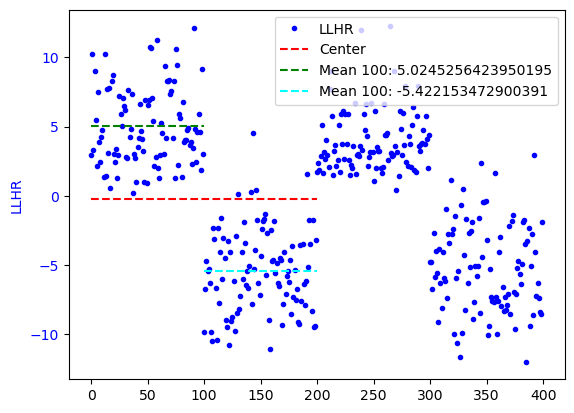

In [28]:
# plt.plot(torch.exp(-model(test_set[0][0])).detach().numpy())
# plt.yscale("log")

# a plot with two y axis (left and right)
fig, ax1 = plt.subplots()
ax1.plot(model(test_set[0][0][:400]).detach().numpy(), color="blue", marker=".", linestyle="None", label="LLHR")
ax1.hlines(
    model(test_set[0][0][:200]).detach().numpy().mean(),
    xmin=0,
    xmax=200,                                                                                                                                                 
    label="Center", 
    color="red",
    linestyle="--")
ax1.hlines(
    model(test_set[0][0][:100]).detach().numpy().mean(),
    xmin=0,
    xmax=100,                                                                                                                                                 
    label=f"Mean 100: {model(test_set[0][0][:100]).detach().numpy().mean()}",
    color="green",
    linestyle="--")
ax1.hlines(
    model(test_set[0][0][100:200]).detach().numpy().mean(),
    xmin=100,
    xmax=200,                                                                                                                                                 
    label=f"Mean 100: {model(test_set[0][0][100:200]).detach().numpy().mean()}",
    color="cyan",
    linestyle="--")
ax1.set_ylabel("LLHR", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
plt.legend()
plt.show()